# Chatbot  
---
- [reference] https://python.langchain.com/v0.2/docs/tutorials/chatbot/  

## Quickstart

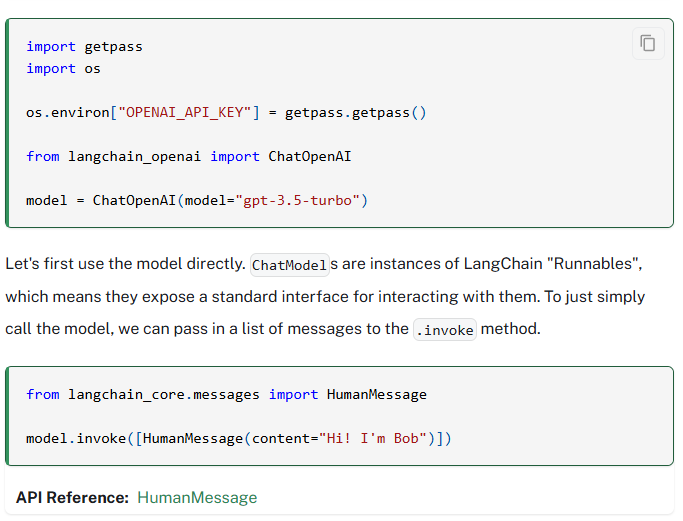

In [1]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from dotenv import load_dotenv


load_dotenv()

llm = ChatOpenAI(
    model_name = 'gpt-4.1-nano',
)


In [2]:
aimessage = llm.invoke([HumanMessage(content="Hi! I'm J.")])
aimessage.content

'Hello, J! Nice to meet you. How can I assist you today?'

In [3]:
aimessage02 = llm.invoke("What's my name?")
aimessage02.content

"I'm sorry, but I don't know your name. How can I assist you today?"

In [4]:
aimessage03 = llm.invoke([HumanMessage(content="What's my name?")])
aimessage03.content

"I'm sorry, but I don't have that information. How can I assist you today?"

In [5]:
aimessage04 = llm.invoke([
    HumanMessage(content="Hi! I'm J."),
    AIMessage(content="Hello J! How can I assist you today!"),
    HumanMessage(content="What's my name?"),
])

aimessage04.content

'Your name is J. Nice to meet you! How can I help you today?'

## Message History
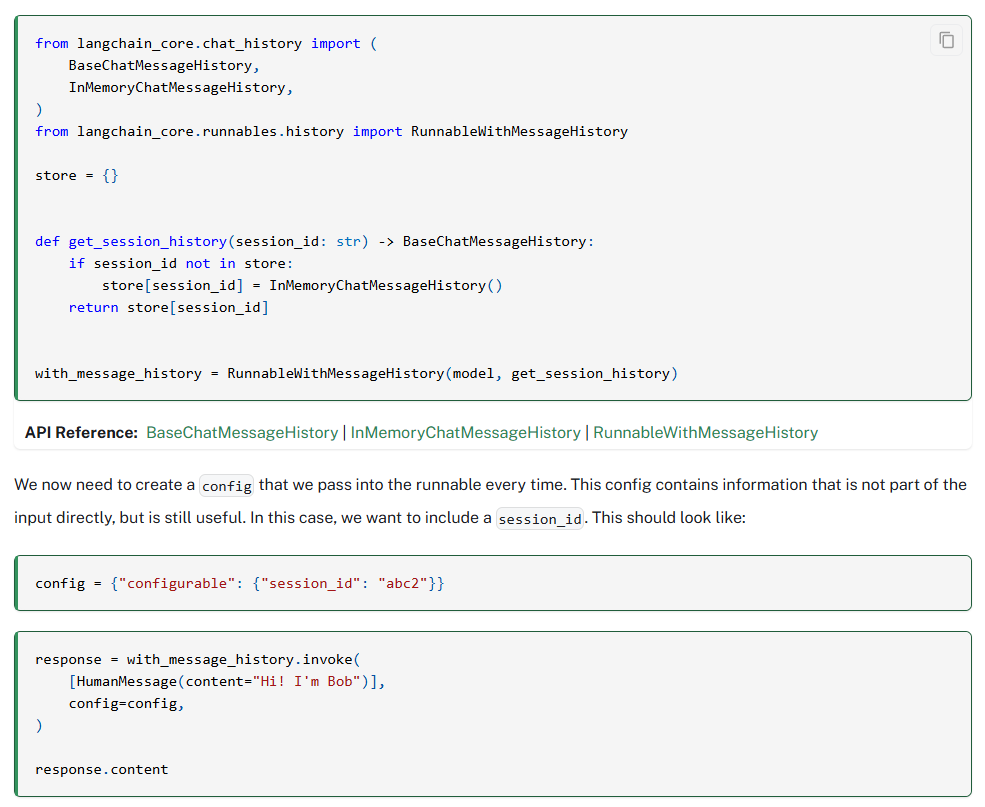

In [6]:
from langchain_core.chat_history import InMemoryChatMessageHistory, BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory


store = {}

def get_session_history(session_id : str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = InMemoryChatMessageHistory()
    return store[session_id]

with_message_history = RunnableWithMessageHistory(llm, get_session_history)


In [7]:
response = with_message_history.invoke(
    [HumanMessage(content="Hi! I'm J.")],
    config={"configurable": {"session_id": "a1"}}
)

response.content

'Hello, J.! Nice to meet you. How can I assist you today?'

In [8]:
response02 = with_message_history.invoke(
    [HumanMessage(content="What's my name?")],
    config={"configurable": {"session_id": "a1"}}
)

response02.content

'Your name is J!'

In [9]:
response03 = with_message_history.invoke(
    [HumanMessage(content="What's my name?")],
    config={"configurable": {"session_id": "b2"}}
)

response03.content

"I'm sorry, but I don't know your name."

## Prompt templates  

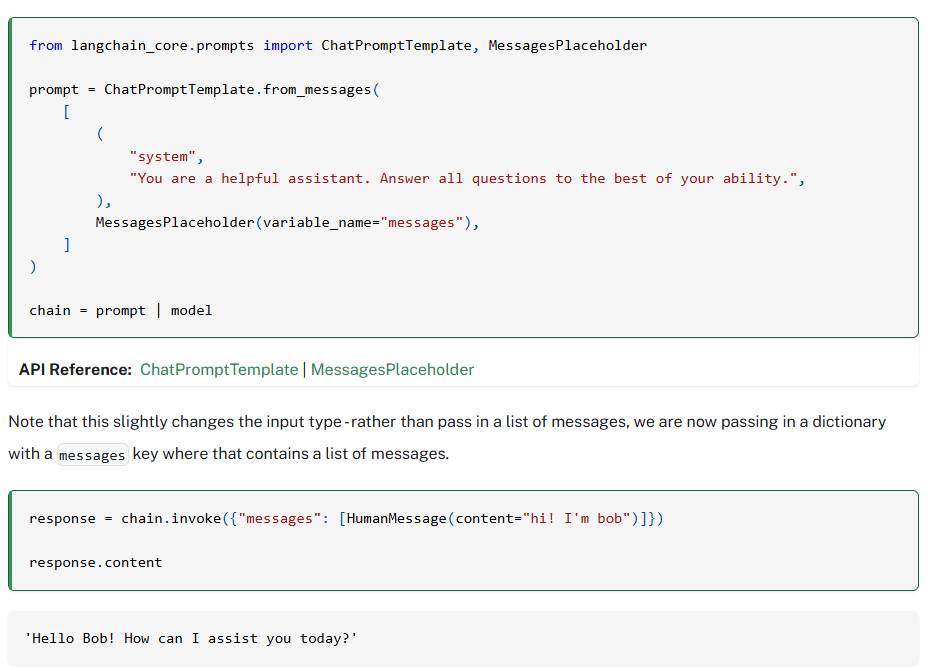

In [10]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages([
    ('system', "You are a helpful assistant. Answer all questions to the best of your ability."),
    MessagesPlaceholder(variable_name="messages")
])

chain = prompt | llm

In [11]:
response04 = chain.invoke({'messages': [HumanMessage(content="Hi! I'm bob.")]})

response04.content

'Hello, Bob! How can I assist you today?'

In [12]:
with_message_history02 = RunnableWithMessageHistory(chain, get_session_history)

response05 = with_message_history02.invoke(
    [HumanMessage(content="Hi! I'm Jim.")], 
    config={"configurable": {"session_id": "c3"}}
)

response05.content

'Hello Jim! Nice to meet you. How can I assist you today?'

In [13]:
response05_test = with_message_history02.invoke(
    [HumanMessage(content="What's my name?")],
    config={"configurable": {"session_id": "c3"}}
)

response05_test.content

'Your name is Jim.'

In [14]:
for message_c3 in get_session_history('c3').messages:
    print(f"[{message_c3.type.upper()}]: {message_c3.content}")


[HUMAN]: Hi! I'm Jim.
[AI]: Hello Jim! Nice to meet you. How can I assist you today?
[HUMAN]: What's my name?
[AI]: Your name is Jim.


In [15]:
def change_config(session_id) :
    return {"configurable": {"session_id": session_id}}

prompt_language = ChatPromptTemplate.from_messages([
    ('system', "You are a helpful assistant. Answer all questions to the best of your ability in {language}."),
    MessagesPlaceholder(variable_name="messages")
])

chain_language = prompt_language | llm

In [16]:
response_language = chain_language.invoke({
    "messages":[HumanMessage(content="Hi! I'm bob2.")], 
    "language": "Korean"
})

response_language.content

'안녕하세요, Bob2님! 어떻게 도와드릴까요?'

Let's now wrap this more complicated chain in a Message History class. This time, because there are multiple keys in the input, we need to specify the correct key to use to save the chat history.

In [17]:
with_message_history02 = RunnableWithMessageHistory(
    chain_language,
    get_session_history,
    input_messages_key="messages",
)


response_language02 = with_message_history02.invoke(
    {"messages": [HumanMessage(content="Hi! I'm Todd.")], "language": "Korean"},
    config=change_config("d4")
)

response_language02.content

'안녕하세요, Todd님! 반갑습니다. 어떤 도움을 드릴까요?'

In [18]:
response_language03 = with_message_history02.invoke(
     {"messages": [HumanMessage(content="What is my name?")], "language": "Korean"},
     config=change_config("d4")
)

response_language03.content

'당신의 이름은 Todd입니다.'

## Managing Conversation History  

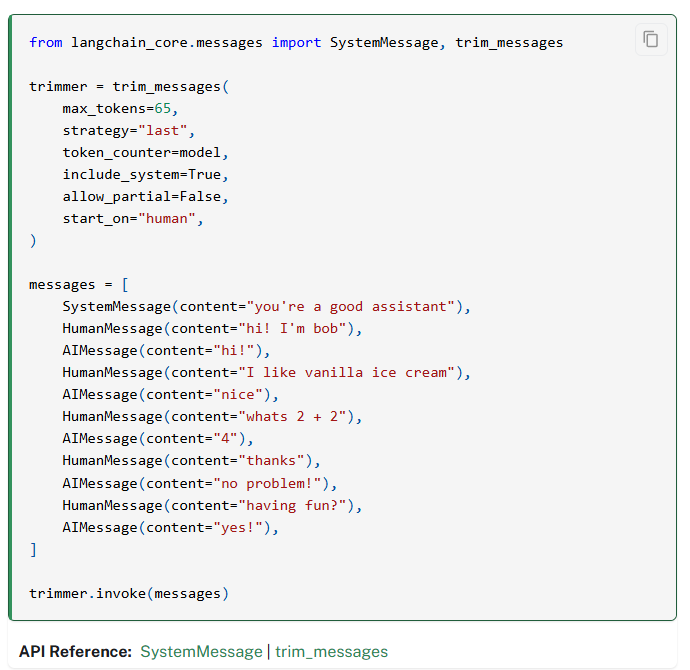

### trim_messages  

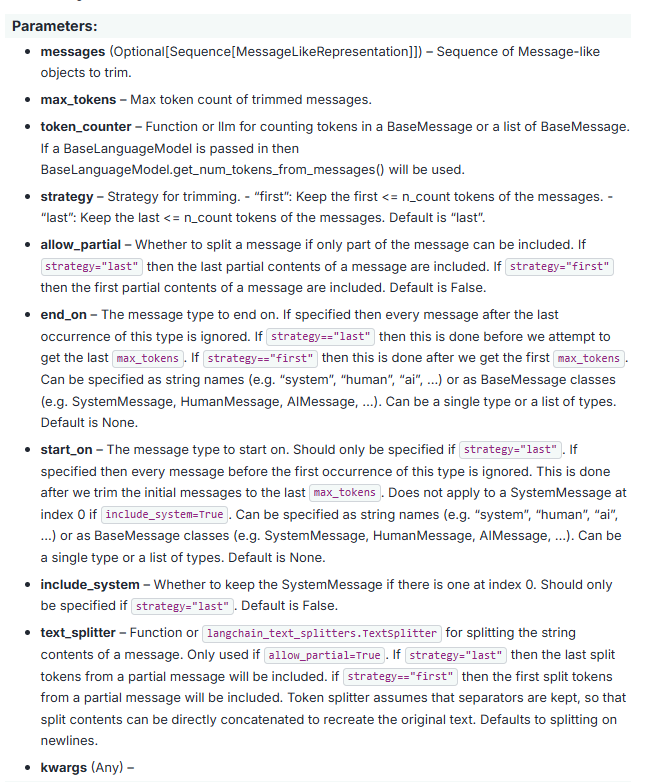

In [19]:
from langchain_core.messages import SystemMessage, trim_messages

model = ChatOpenAI(model_name='gpt-3.5-turbo')

trimmer = trim_messages(
    max_tokens=70,
    strategy="last",
    token_counter=model,
    include_system=True,
    allow_partial=False,
    start_on="human",
)

messages = [
    SystemMessage(content="you're a good assistant."),
    HumanMessage(content="hi! I'm bob."),
    AIMessage(content="hi!"),
    HumanMessage(content="I like vanilla ice cream."),
    AIMessage(content="nice."),
    HumanMessage(content="math : 2 + 2?"),
    AIMessage(content="4"),
    HumanMessage(content="thanks"),
    AIMessage(content="no problem!"),
    HumanMessage(content="having fun?"),
    AIMessage(content="yes!"),
]

trim_message = trimmer.invoke(messages)
trim_message

[SystemMessage(content="you're a good assistant.", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='math : 2 + 2?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='yes!', additional_kwargs={}, response_metadata={})]

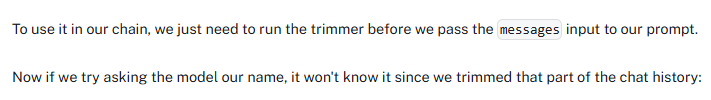

In [20]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough

chain_trimmer = (
    RunnablePassthrough.assign(messages=itemgetter("messages") | trimmer)
    | prompt_language
    | model
)

response_trimmer = chain_trimmer.invoke({
    "messages": messages + [HumanMessage(content="what's my name?")],
    "language": "한국어"
})

print(response_trimmer.content)

response_trimmer02 = chain_trimmer.invoke({
    "messages": messages + [HumanMessage(content="what math problem did i ask?")],
    "language": "english"
    })

print(response_trimmer02.content)

trim_message = trimmer.invoke(messages)
trim_message

죄송합니다, 당신의 이름은 알 수 없습니다.
You asked "2 + 2?"


[SystemMessage(content="you're a good assistant.", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='math : 2 + 2?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='yes!', additional_kwargs={}, response_metadata={})]

In [21]:
with_message_history03 = RunnableWithMessageHistory(
    chain_trimmer,
    get_session_history,
    input_messages_key="messages",
)

response_trimmer03 = with_message_history03.invoke(
    {
        "messages": messages + [HumanMessage(content="what math problem did i ask?")],
        "language": "한국어"
    },
    config=change_config("h8")
)
response_trimmer03.content

'You asked, "2 + 2?"'

## Streaming  

In [22]:
for r in with_message_history02.stream(
    {"messages": [HumanMessage(content="hi! I'm todd. tell me a joke.")], "language": "Korean"},
    config=change_config("f5")
):   
    print(r.content, end="|")


|안|녕하세요|,| Todd|!| 저|에게| 농|담| 좀| 들어|볼|래|요|?|  
|왜| 바|다|에| 가|면| 항상| 웃|는| 물|고|기가| 있을|까요|?|  
|왜|냐|하면|,| 그|게| 바로| ‘|해|피| 피|시|’|거|든|요|!||